In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib



  0%|          | 0/150 [00:00<?, ?it/s]

Training 102
cost -1.094406247138977


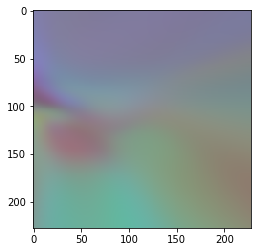


  7%|▋         | 10/150 [00:02<00:38,  3.68it/s]

cost -3.723353385925293


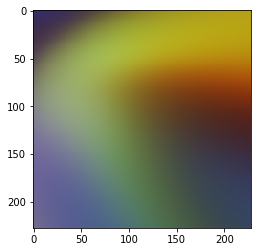


 13%|█▎        | 20/150 [00:05<00:34,  3.72it/s]

cost -5.929654598236084


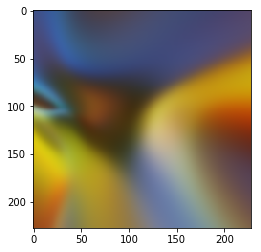


 20%|██        | 30/150 [00:08<00:32,  3.72it/s]

cost -5.412782192230225


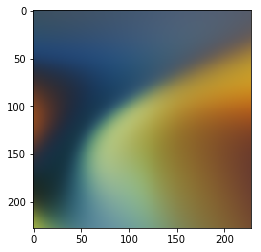


 27%|██▋       | 40/150 [00:10<00:29,  3.70it/s]

cost -6.794759273529053


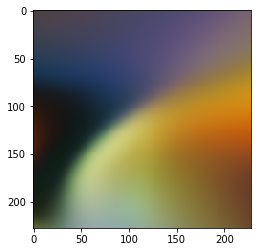


 33%|███▎      | 50/150 [00:13<00:27,  3.70it/s]

cost -9.038215637207031


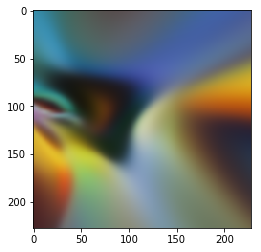


 40%|████      | 60/150 [00:16<00:24,  3.68it/s]

cost -6.460935115814209


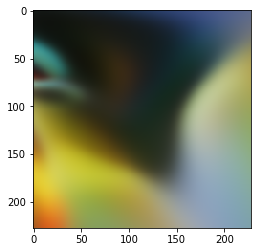


 47%|████▋     | 70/150 [00:19<00:21,  3.69it/s]

cost -8.150653839111328


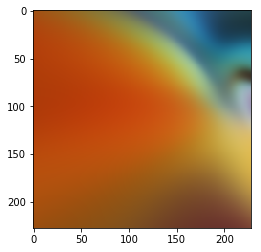


 53%|█████▎    | 80/150 [00:22<00:19,  3.68it/s]

cost -10.452268600463867


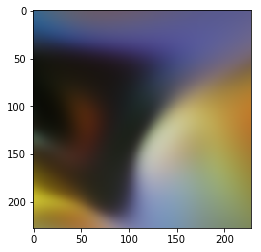


 60%|██████    | 90/150 [00:25<00:16,  3.68it/s]

cost -10.041116714477539


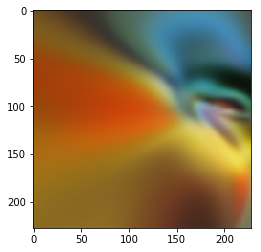


 67%|██████▋   | 100/150 [00:27<00:13,  3.66it/s]

cost -8.11401081085205


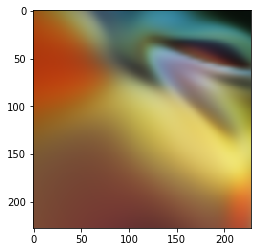


 73%|███████▎  | 110/150 [00:30<00:10,  3.65it/s]

cost -10.999885559082031


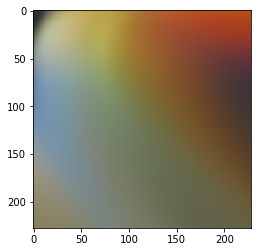


 80%|████████  | 120/150 [00:33<00:08,  3.66it/s]

cost -10.089066505432129


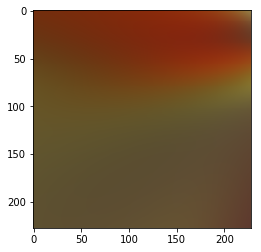


 87%|████████▋ | 130/150 [00:36<00:05,  3.66it/s]

cost -10.536698341369629


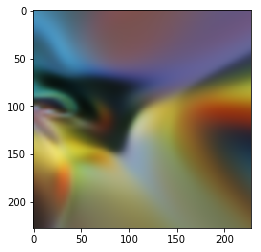


 93%|█████████▎| 140/150 [00:39<00:02,  3.65it/s]

cost -7.410242080688477


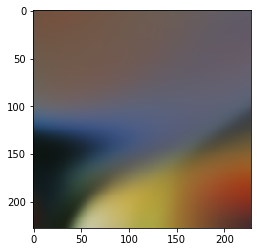


  0%|          | 0/50 [00:00<?, ?it/s]

Changed learning rate to 0.0002
cost -12.301496505737305


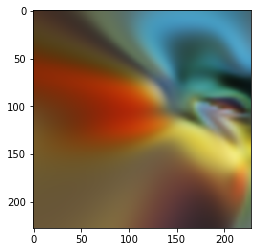


 20%|██        | 10/50 [00:02<00:11,  3.45it/s]

cost -14.34829044342041


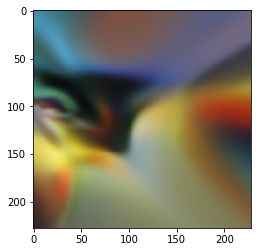


 40%|████      | 20/50 [00:05<00:08,  3.63it/s]

cost -15.108572006225586


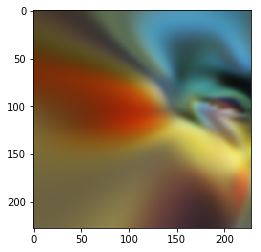


 60%|██████    | 30/50 [00:08<00:05,  3.62it/s]

cost -11.349325180053711


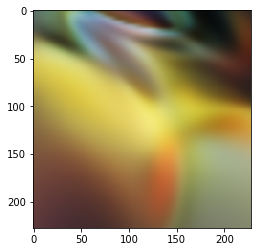


 80%|████████  | 40/50 [00:11<00:02,  3.63it/s]

cost -14.075217247009277


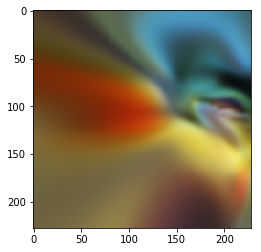


100%|██████████| 50/50 [00:14<00:00,  3.63it/s]

Took 56.379197120666504 seconds
Saving 102
Took 0.9312353134155273 seconds


In [8]:
import time
from skimage.io import imsave
from dreamz.utils import get_latest_filename, tch_im_to_np
from dreamz.cppn import get_xy_mesh, CPPNNet
from dreamz.render import train_visualiser
from dreamz.torch_utils import Lambda, adjust_learning_rate
from dreamz.cppn import composite_activation
import torch
from torch import nn
from torchvision import models
from torch.nn import functional as F
from torch import optim
import numpy as np


class Net(nn.Module):
    def __init__(self, base_model, reps=2, output_channels=3):
        super(Net, self).__init__()
        self.base_model = base_model

        s = self.base_model.output_channels

        self.conv1 = self.get_group_of_layers(reps, s, s)
        self.conv2 = self.get_group_of_layers(reps - 1, s * 2, s)
        self.conv3 = nn.Conv2d(s * 2, output_channels, 3)
        self.final_act = nn.Sigmoid()

    def get_group_of_layers(self, reps, s0, s, k=1):
        this = []
        for i in range(reps):
            this += [nn.Conv2d(s0, s, k)]
            nn.init.normal_(
                this[-1].weight,
                std=np.sqrt(1 / (s0 * (k ** 2)))
            )
#             this += [nn.ReLU6()]
            this += [Lambda(composite_activation)]
            s0 = s * 2
        return nn.Sequential(*this)

    def forward(self, x):
        x = self.base_model.layers(x)
        x = self.conv1(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv2(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv3(x)
        x = self.final_act(x)
        return x[:, :, 3:-3, 3:-3]


def train(size, widths, imagenet_model, chan_to_opt, log_interval):
    base = CPPNNet(widths, output_channels=widths[-1])
    viz = Net(base, reps=1).to(device)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
    std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

    def imgnet_objective(output):
        r = imagenet_model((output - mean) / std)
    #     return torch.mean((r - targ) ** 2)
        return -r[:, chan_to_opt].mean()

    xy = get_xy_mesh(size).to(device)
    xy2 = get_xy_mesh([i * 2 for i in size]).to(device)

    def im_gen_fn(num=16):
        xy_crop = []
        h, w = size
        for i in range(num):
            if np.random.rand() < 0.5:
                x0 = np.random.choice([0, w - h])
                x1 = x0 + h
                xy_crop.append(xy[:, :, :, x0:x1])
            else:
                x0 = np.random.randint(0, xy2.shape[3] - h)
                x1 = x0 + h
                y0 = np.random.randint(0, xy2.shape[2] - h)
                y1 = y0 + h
                xy_crop.append(xy2[:, :, y0:y1, x0:x1])
        xy_crop = torch.cat(xy_crop, 0)
        return viz(xy_crop)
    opt = optim.Adam(viz.parameters(), lr=0.002)
    train_visualiser(imgnet_objective, im_gen_fn, opt, iters=150, log_interval=log_interval)
    adjust_learning_rate(opt, 0.1)
    train_visualiser(imgnet_objective, im_gen_fn, opt, iters=50, log_interval=log_interval)
    return viz


def get_imagenet_model():
    model = models.resnet18(pretrained=True)
    model = nn.Sequential(*(
        [i for i in model.children()][:-2] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
    # model = nn.Sequential(*(
    #     [i for i in model.children()][:-3] + [
    #         nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    #         Lambda(lambda x: x[:, :, 0, 0])]))
    return model.eval()


device = 'cuda'
ims_savedir = '../data/output_ims2/'
widths = [20] * 8
size = [59, 105]

imagenet_model = get_imagenet_model().to(device)


chan_to_opt = 102
log_interval = 10

now = time.time()
print('Training {}'.format(chan_to_opt))
viz = train(size, widths, imagenet_model, chan_to_opt, log_interval)
print('Took {} seconds'.format(time.time() - now))
now = time.time()
print('Saving {}'.format(chan_to_opt))
xy_big = get_xy_mesh([277, 502]).to(device)
res = viz(xy_big)
imsave(get_latest_filename(ims_savedir), tch_im_to_np(res))
print('Took {} seconds'.format(time.time() - now))
